<a href="https://colab.research.google.com/github/chetan-parthiban/Conceptors/blob/master/Conceptors_on_Not_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testing the effect of Conceptors on Embeddings other than BERT

# Obtain embeddings of interest (GloVe, Fasttext, ELMo)

In [0]:
!pip install flair
!pip install allennlp

     |████████████████████████████████| 5.4MB 2.7MB/s 
  Found existing installation: botocore 1.12.148
    Uninstalling botocore-1.12.148:
      Successfully uninstalled botocore-1.12.148


In [0]:
from flair.embeddings import WordEmbeddings
from flair.embeddings import ELMoEmbeddings
from flair.data import Sentence
glove = WordEmbeddings('glove')
fast = WordEmbeddings('crawl')
ELMo = ELMoEmbeddings('original')

2019-05-21 15:50:32,110 this function is deprecated, use smart_open.open instead
2019-05-21 15:50:34,455 this function is deprecated, use smart_open.open instead


# Obtain the Brown Corpus and Embeddings
**Corpus** <br>
brown_corpus <br> <br>

**Embeddings** <br>
brown_glove <br>
brown_fast <br>
bronw_ELMo <br>

In [0]:
import numpy as np
import torch
import matplotlib.pyplot as plt
t = np.transpose
%matplotlib inline
from tqdm import tqdm
import nltk
nltk.download('brown')

from nltk.corpus import brown
brown_corpus = brown.sents()
brown_corpus = brown_corpus[:10000]

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [0]:
# brown_ELMo = []
# for s in tqdm(brown_corpus):
#     sentence = Sentence(' '.join(s))
#     ELMo.embed(sentence)
#     sent_emb = torch.stack([token.embedding for token in sentence]).numpy()
#     brown_ELMo.append(sent_emb)

# Initialize Some Functions and Word Lists
**Conceptor Functions** <br>
get_conceptor <br>
get_negated <br>
get_apply_negated <br>
post_process_cn_matrix <br> <br>

**Other Functions** <br>
do_plot <br>
pick_embeddings <br> <br>

**Word Lists** <br>
gender_list_pronouns <br>
gender_list_extended <br>
gender_list_propernouns <br>
gender_list_all <br>

In [0]:
# Gender word lists
!git clone https://github.com/uclanlp/gn_glove
!git clone https://github.com/uclanlp/corefBias
!wget https://www.cs.cmu.edu/Groups/AI/areas/nlp/corpora/names/female.txt
!wget https://www.cs.cmu.edu/Groups/AI/areas/nlp/corpora/names/male.txt
    
# our code for debiasing -- also includes word lists    
!git clone https://github.com/jsedoc/ConceptorDebias

In [0]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
from   sklearn.decomposition import PCA
from   sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding, MDS, SpectralEmbedding
from   sklearn.preprocessing import StandardScaler

np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)
plt_style = 'seaborn-talk'

# Experimental: HDBScan is a state-of-the-art clustering algorithm
hdbscan_available = True
try:
    import hdbscan
except ImportError:
    hdbscan_available = False

In [0]:
# Get Winobias word lists
winoWordsPath = './' + 'corefBias/WinoBias/wino/extra_gendered_words.txt'
male_vino_extra = []
female_vino_extra = []
with open(winoWordsPath, "r+") as f_in:
    for line in f_in:
        male_vino_extra.append(line.split('\t')[0])
        female_vino_extra.append(line.strip().split('\t')[1])

# Get CMU word lists
cmuMaleWordPath = './' + 'male.txt'
male_cmu = []
with open(cmuMaleWordPath, "r+") as f_in:
  for line in f_in:
    w = line.strip()
    if len(w)>0 and w[0] != '#':
      male_cmu.append(w)
cmuFemaleWordPath = './' + 'female.txt'
female_cmu = []
with open(cmuFemaleWordPath, "r+") as f_in:
  for line in f_in:
    w = line.strip()
    if len(w)>0 and w[0] != '#':
      female_cmu.append(w)
    
# Get gnGlove word lists
gnGloveFemaleWordPath = './' + 'gn_glove/wordlist/female_word_file.txt'
female_gnGlove = []
with open(gnGloveFemaleWordPath, "r+") as f_in:
    for line in f_in:
        female_gnGlove.append(line.strip())
gnGloveMaleWordPath = './' + 'gn_glove/wordlist/male_word_file.txt'
male_gnGlove = []
with open(gnGloveMaleWordPath, "r+") as f_in:
    for line in f_in:
        male_gnGlove.append(line.strip())
    
# Get WEAT lists and conceptor functionality
from ConceptorDebias.Conceptors.conceptor_fxns import *
from ConceptorDebias.lists import WEAT_lists
WEATLists = WEAT_lists.WEATLists()

Perform a nice plot of some data where different labels are colored differently

In [0]:
def do_plot(X_fit, title=None, labels = ['']):
    dimension = X_fit.shape[1]
    label_types = sorted(list(set(labels)))
    num_labels = len(label_types)
    colors = cm.Accent(np.linspace(0,1,num_labels))
    with plt.style.context(plt_style):
        fig = plt.figure()
        if dimension == 2:
            ax = fig.add_subplot(111)
            
            for lab,col in zip(label_types, colors):
                if num_labels>1:
                    idxs = [i for i,v in enumerate(labels) if v == lab]
                    ax.scatter([X_fit[i,0] for i in idxs], 
                               [X_fit[i,1] for i in idxs], 
                               c = [col], label = lab)
                else:
                    ax.scatter(X_fit[:,0],
                               X_fit[:,1],
                               c = [col])
        elif dimension == 3:
            ax = fig.add_subplot(111, projection ='3d')
            for lab, col in zip(label_types,colors):
                ax.scatter(X_fit[labels==lab,0],
                           X_fit[labels==lab,1],
                           X_fit[labels==lab,2],
                           c=[col])
        else:
            raise Exception('Bad Dimensions')
        plt.title(title)
        if num_labels >1:
            ax.legend()
        plt.show()

Find all embeddings of words from a world list

In [0]:
def pick_embeddings_contextual(corpus,sent_embs,word_list):
    X = []
    labels = []
    sents = []
    for i, s in enumerate(corpus):
        for j, w in enumerate(s):
            if w in word_list:
                X.append(sent_embs[i][j])
                labels.append(w)
                sents.append(s)
    return (X, labels, sents)

In [0]:
def pick_embeddings(embedding, word_list):
    labels = []
    sentence = Sentence(' '.join(word_list))
    embedding.embed(sentence)
    X = torch.stack([token.embedding for token in sentence]).numpy()
    for w in sentence:
        labels.append(w)
    return X, labels

Some conceptor implementations

In [0]:
def get_conceptor(x, alpha = 1):
    k = x.shape[1]
    corr = (x @ x.T)*(1/k)
    return corr @ np.linalg.inv(corr + (alpha ** (-2))*np.eye(x.shape[0]))

def get_negated(x,alpha = 1):
    conceptor = get_conceptor(x,alpha)
    return np.identity(conceptor.shape[0]) - conceptor

def get_apply_negated(x,alpha = 1):
    neg = get_negated(x, alpha = alpha)
    newX = (neg @ x).T
    return neg, newX

def get_corr(x):
    return (x @ x.T)*(1/x.shape[1])

In [0]:
gender_list_pronouns = WEATLists.W_7_Male_terms + WEATLists.W_7_Female_terms + WEATLists.W_8_Male_terms + WEATLists.W_8_Female_terms
gender_list_pronouns = list(set(gender_list_pronouns))

pronouns_male = WEATLists.W_7_Male_terms + WEATLists.W_8_Male_terms
pronouns_male = list(set(pronouns_male))
pronouns_female = WEATLists.W_8_Female_terms + WEATLists.W_8_Female_terms
pronouns_female = list(set(pronouns_female))


gender_list_extended = male_vino_extra + female_vino_extra + male_gnGlove + female_gnGlove
gender_list_extended = list(set(gender_list_extended))

extended_male = male_vino_extra + male_gnGlove
extended_male = list(set(extended_male))
extended_female = female_vino_extra + female_gnGlove
extended_female = list(set(extended_female))

gender_list_propernouns = male_cmu + female_cmu
gender_list_propernouns = list(set(gender_list_propernouns))

propernouns_male = list(set(male_cmu))
propernouns_female = list(set(female_cmu))

gender_list_all = gender_list_pronouns + gender_list_extended + gender_list_propernouns
gender_list_all = list(set(gender_list_all))

all_male = list(set(pronouns_male + extended_male + propernouns_male))
all_female = list(set(pronouns_female + extended_female + propernouns_female))

# Perform Some Analysis 

ANALYSING GLOVE EMBEDDINGS 

Word List
['hers', 'male', 'grandmother', 'father', 'him', 'woman', 'boy', 'man', 'he', 'uncle', 'girl', 'aunt', 'mother', 'brother', 'daughter', 'his', 'son', 'her', 'sister', 'female', 'she', 'grandfather']


97.6730083345387


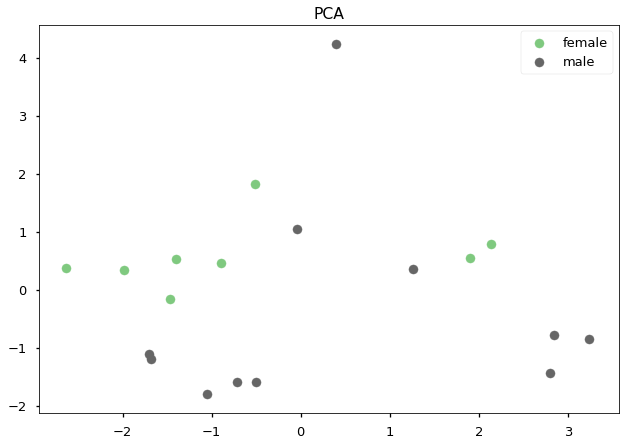

0.34703678
42.15267449897664


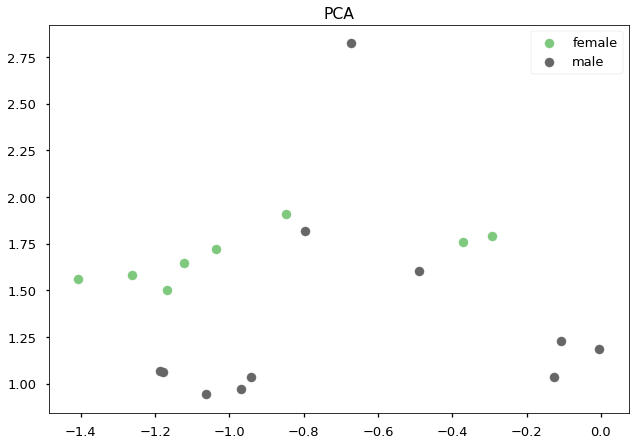

In [0]:
print('ANALYSING GLOVE EMBEDDINGS \n')
print('Word List')
gender_list = gender_list_pronouns
print(gender_list)
print('\n')

data, _ = pick_embeddings(fast,gender_list)
labels = gender_list

male, male_label = pick_embeddings(glove,pronouns_male)
male_label = ['male']*len(male_label)
female, female_label = pick_embeddings(glove,pronouns_female)
female_label = ['female']*len(female_label)
data = np.hstack((male.T,female.T)).T
labels =  male_label+female_label


pca = PCA(n_components = 2)
pca.fit(data)
transformed = pca.transform(data)
corr = get_corr(data.T)
corr = corr * 1/corr[0][0]
print(np.linalg.norm(np.eye(corr.shape[0]) - corr))
do_plot(transformed, 'PCA', labels=labels)
print(np.mean(abs(np.mean(data,0))))

neg, newData = get_apply_negated(data.T)
transformed = pca.transform(newData)
corr = get_corr(newData.T)
corr = corr * 1/corr[0][0]
print(np.linalg.norm(np.eye(corr.shape[0]) - corr))
do_plot(transformed, 'PCA', labels=labels)


# pca_full = PCA()
# pca_full.fit(AB)
# transformed = pca_full.transform(AB)
# tsne = TSNE()
# transformed = tsne.fit_transform(transform)
# do_plot(transformed, 't-SNE', labels=gender_list)